In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set Random seed
torch.manual_seed(42)

In [2]:
# Load Fashion-MNIST CSV
df = pd.read_csv("/content/fashion-mnist.csv")
x = df.iloc[:, 1:].values / 255.0
y = df.iloc[:, 0].values

# Split the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [3]:
# Create customDataset class
class FlatDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

# Create traning & test dataset object
train_dataset_nn = FlatDataset(x_train, y_train)
test_dataset_nn = FlatDataset(x_test, y_test)

# Create train & test loader
train_loader_nn = DataLoader(train_dataset_nn, batch_size=32, shuffle=True)
test_loader_nn = DataLoader(test_dataset_nn, batch_size=32, shuffle=False)


In [4]:
# Define NN class
class MyNN(nn.Module):
    def __init__(self, num_features, dropout_prob=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_prob),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_prob),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

model_nn = MyNN(x_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

In [5]:
# Set Epocs
epochs = 20
train_acc_nn, test_acc_nn, loss_history_nn = [], [], []

# Traning Loop
for epoch in range(epochs):
    model_nn.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in train_loader_nn:
        # Forward Loss
        out = model_nn(X)
        # Calculate loss
        loss = criterion(out, y)
        # Back Pass
        optimizer.zero_grad()
        loss.backward()
        # Update grad
        optimizer.step()

        total_loss += loss.item()
        _, pred = torch.max(out, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_acc_nn.append(correct / total)
    loss_history_nn.append(total_loss / len(train_loader_nn))

# Set model to eval mode
    model_nn.eval()

# evaluation code
    correct, total = 0, 0
    with torch.no_grad(): # No Gradient need
        for X, y in test_loader_nn:
            out = model_nn(X)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    test_acc_nn.append(correct / total)

    print(f"Epoch {epoch+1}: Loss = {loss_history_nn[-1]:.4f}, Train Acc = {train_acc_nn[-1]*100:.2f}%, Test Acc = {test_acc_nn[-1]*100:.2f}%")

Epoch 1: Loss = 0.6214, Train Acc = 78.64%, Test Acc = 84.02%
Epoch 2: Loss = 0.5111, Train Acc = 81.94%, Test Acc = 85.08%
Epoch 3: Loss = 0.4875, Train Acc = 82.80%, Test Acc = 85.97%
Epoch 4: Loss = 0.4656, Train Acc = 83.43%, Test Acc = 86.07%
Epoch 5: Loss = 0.4607, Train Acc = 83.59%, Test Acc = 85.99%
Epoch 6: Loss = 0.4440, Train Acc = 84.16%, Test Acc = 85.47%
Epoch 7: Loss = 0.4412, Train Acc = 84.49%, Test Acc = 86.28%
Epoch 8: Loss = 0.4378, Train Acc = 84.54%, Test Acc = 86.63%
Epoch 9: Loss = 0.4298, Train Acc = 84.82%, Test Acc = 86.42%
Epoch 10: Loss = 0.4287, Train Acc = 84.86%, Test Acc = 86.96%
Epoch 11: Loss = 0.4225, Train Acc = 85.08%, Test Acc = 85.81%
Epoch 12: Loss = 0.4141, Train Acc = 85.12%, Test Acc = 86.85%
Epoch 13: Loss = 0.4062, Train Acc = 85.49%, Test Acc = 86.54%
Epoch 14: Loss = 0.4063, Train Acc = 85.79%, Test Acc = 86.67%
Epoch 15: Loss = 0.4093, Train Acc = 85.40%, Test Acc = 87.29%
Epoch 16: Loss = 0.4053, Train Acc = 85.74%, Test Acc = 87.06%
E

In [6]:
# Create customDataset class
class CnnDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

# Create traning and test dataset object
train_dataset_cnn = CnnDataset(x_train, y_train)
test_dataset_cnn = CnnDataset(x_test, y_test)

# Create train & test loader
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=32, shuffle=False)

# Define NN class
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
# Instatiate the Model
model_cnn = MyCNN()

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

In [7]:
train_acc_cnn, test_acc_cnn, loss_history_cnn = [], [], []

# Traning Loop
for epoch in range(epochs):
    model_cnn.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in train_loader_cnn:

      # Forward Loss
        out = model_cnn(X)

      # Calculate loss
        loss = criterion(out, y)

      # Back Pass
        optimizer.zero_grad()
        loss.backward()

      # Update grad
        optimizer.step()

        total_loss += loss.item()
        _, pred = torch.max(out, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_acc_cnn.append(correct / total)
    loss_history_cnn.append(total_loss / len(train_loader_cnn))

# Set model to eval mode
    model_cnn.eval()

  # evaluation code
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in test_loader_cnn:
            out = model_cnn(X)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    test_acc_cnn.append(correct / total)

    print(f"Epoch {epoch+1}: Loss = {loss_history_cnn[-1]:.4f}, Train Acc = {train_acc_cnn[-1]*100:.2f}%, Test Acc = {test_acc_cnn[-1]*100:.2f}%")

Epoch 1: Loss = 0.4030, Train Acc = 85.44%, Test Acc = 89.26%
Epoch 2: Loss = 0.2790, Train Acc = 89.81%, Test Acc = 91.12%
Epoch 3: Loss = 0.2329, Train Acc = 91.48%, Test Acc = 91.48%
Epoch 4: Loss = 0.2134, Train Acc = 91.99%, Test Acc = 90.50%
Epoch 5: Loss = 0.1816, Train Acc = 93.29%, Test Acc = 91.53%
Epoch 6: Loss = 0.1645, Train Acc = 93.87%, Test Acc = 90.91%
Epoch 7: Loss = 0.1493, Train Acc = 94.43%, Test Acc = 91.47%
Epoch 8: Loss = 0.1317, Train Acc = 94.96%, Test Acc = 91.80%
Epoch 9: Loss = 0.1233, Train Acc = 95.42%, Test Acc = 92.30%
Epoch 10: Loss = 0.1131, Train Acc = 95.77%, Test Acc = 92.03%
Epoch 11: Loss = 0.1004, Train Acc = 96.23%, Test Acc = 91.87%
Epoch 12: Loss = 0.0941, Train Acc = 96.51%, Test Acc = 91.97%
Epoch 13: Loss = 0.0861, Train Acc = 96.75%, Test Acc = 90.63%
Epoch 14: Loss = 0.0817, Train Acc = 96.97%, Test Acc = 92.57%
Epoch 15: Loss = 0.0813, Train Acc = 97.00%, Test Acc = 92.03%
Epoch 16: Loss = 0.0723, Train Acc = 97.25%, Test Acc = 92.12%
E

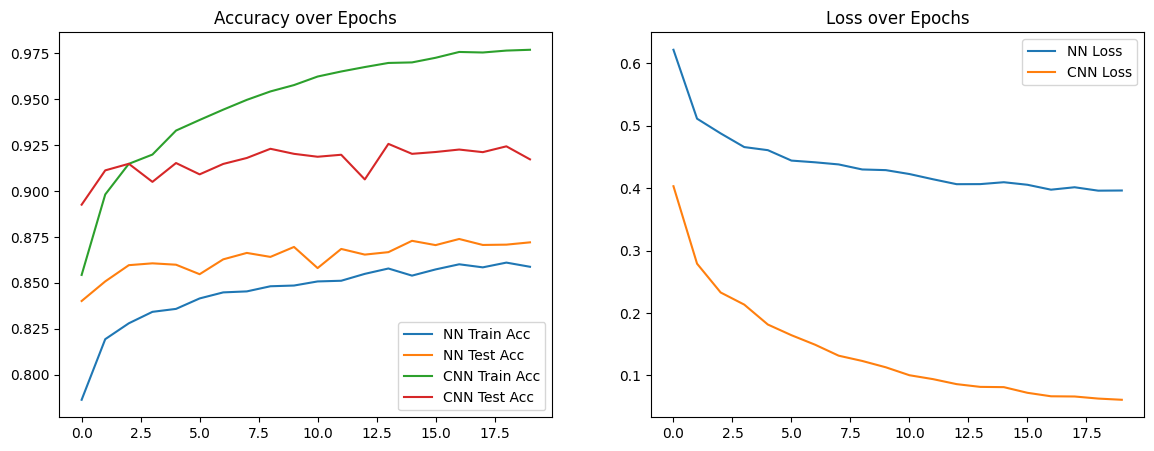

In [8]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_acc_nn, label="NN Train Acc")
plt.plot(test_acc_nn, label="NN Test Acc")
plt.plot(train_acc_cnn, label="CNN Train Acc")
plt.plot(test_acc_cnn, label="CNN Test Acc")
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss_history_nn, label="NN Loss")
plt.plot(loss_history_cnn, label="CNN Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

NN Pred:


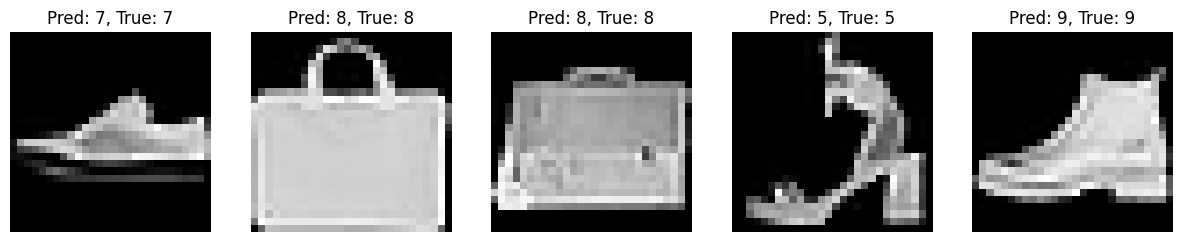

CNN Pred:


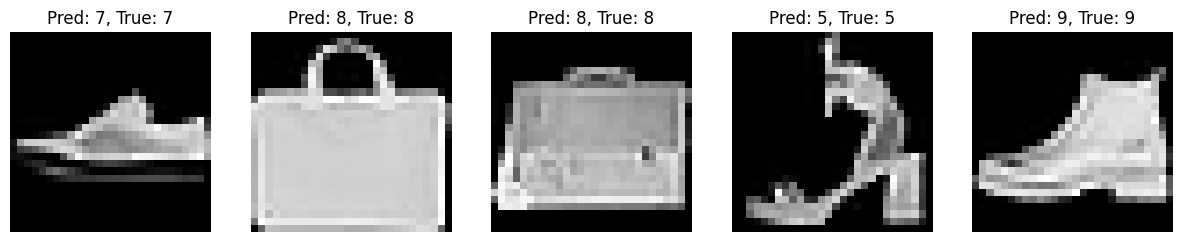

In [10]:
def show_predictions(model, dataset, is_cnn=False):
    model.eval()
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        input_tensor = image.unsqueeze(0)
        if not is_cnn:
            input_tensor = input_tensor.view(1, -1)
            # Reshape the image tensor to 28x28 for plotting
            image = image.view(28, 28)
        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, 1).item()
        axs[i].imshow(image.squeeze(), cmap="gray")
        axs[i].set_title(f"Pred: {pred}, True: {label}")
        axs[i].axis('off')
    plt.show()

print("NN Pred:")
show_predictions(model_nn, test_dataset_nn)

print("CNN Pred:")
show_predictions(model_cnn, test_dataset_cnn, is_cnn=True)

In [11]:
print(f"NN Test Accuracy: {test_acc_nn[-1]*100:.2f}%")
print(f"CNN Test Accuracy: {test_acc_cnn[-1]*100:.2f}%")
improvement = test_acc_cnn[-1] - test_acc_nn[-1]
print(f"CNN better than NN by {improvement*100:.2f}%")

NN Test Accuracy: 87.21%
CNN Test Accuracy: 91.72%
CNN better than NN by 4.52%
